# Building a Web-Search-Enabled Chatbot (LangGraph Version)

## 1. Setup

In [2]:
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Any
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import AIMessageChunk, BaseMessage

# Load environment variables
load_dotenv(".env")

# Model name
MODEL_NAME = "gpt-5-mini"

## 2. Define Tools

In [3]:
# Initialize tools
tavily_search = TavilySearch(
    max_results=2,                 # Number of results to fetch
    search_depth="basic",          # "basic" (fast) or "advanced" (higher quality)
    include_answer=False,          # Do not include Tavily's short generated answer
    include_raw_content=False,     # Include raw HTML content (watch token usage)
    include_images=False,          # Include image URLs
    # include_domains=["go.jp"],   # Restrict to specific domains
    # exclude_domains=["wikipedia.org"] # Exclude specific domains
)

# Format Tavily results into an LLM-friendly string
def format_tavily_results(tavily_response: dict) -> str:
    results = tavily_response.get("results", [])
    if not results:
        return "(No search results)"

    lines = []
    for i, r in enumerate(results, 1):
        title = r.get("title", "")
        content = r.get("content", "")
        url = r.get("url", "")
        lines.append(f"[{i}] {title}\n{content}\nsource: {url}")
    return "\n\n".join(lines)

# A wrapper tool that returns formatted Tavily results
@tool
def tavily_search_formatted(query: str) -> str:
    """Web search (Tavily). Returns formatted top results."""
    tavily_response = tavily_search.invoke({"query": query})
    return format_tavily_results(tavily_response)

@tool
def internal_search(query: str) -> str:
    """(Demo mock) Returns Lucky company's internal rules."""

    rules = """
        Lucky Company Internal Rules
        Every morning, start work after telling the version of yourself in the mirror: "Today, I'm lucky."
        Celebrate coworkers' success as your own, and circulate good "luck" throughout the company.
        No matter what trouble arises, say "Lucky!" out loud first, then think through solutions.
        """
    return rules

tools = [tavily_search_formatted, internal_search]

## 3. Prepare Nodes and the Graph

In [4]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# Initialize the model
model = ChatOpenAI(model=MODEL_NAME)
model_with_tools = model.bind_tools(tools)

prompt_text = """
You are a helpful assistant. Use the best tool as needed.
If you answer after calling a tool (only when the tool result includes URLs), do the following:
- Add the source numbers you used at the end of your answer (e.g., [1][2])
- Finally, list the source numbers and URLs as bullet points
"""

# Keep the prompt template simple
# Adding a SystemMessage helps stabilize behavior
prompt = ChatPromptTemplate.from_messages([
    ("system", prompt_text),
    MessagesPlaceholder(variable_name="messages")
])
my_chain = prompt | model_with_tools

# Chatbot node
def chatbot(state: State) -> dict[str, Any]:
    response = my_chain.invoke(state)
    return {"messages": [response]}

# Use ToolNode (also supports parallel tool execution automatically)
tool_node = ToolNode(tools)

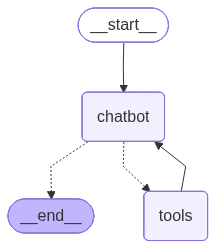

In [5]:
# Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("chatbot", chatbot)
builder.add_node("tools", tool_node) # Often named "tools" by convention

# Define edges
builder.add_edge(START, "chatbot")

# Conditional edges (automated routing)
# The logic "if there is a tool call, go to tools; otherwise end" is handled by tools_condition.
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# After tool execution, always return to the chatbot (LLM) to summarize the results
builder.add_edge("tools", "chatbot")

# Initialize the checkpointer
memory = InMemorySaver()

# Pass the checkpointer at compile time
search_agent = builder.compile(checkpointer=memory)

# Visualize the graph
display(Image(search_agent.get_graph().draw_mermaid_png()))

## 4. Main Loop

In [6]:
# Generate a random UUID and set it as thread_id
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    user_input = input("Enter a message:")
    if user_input.strip() == "":
        break
    print(f"Question: {user_input}")

    # Searching flag
    is_spinning = False

    # Run the agent and stream the response
    for chunk, metadata in search_agent.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config,
        stream_mode="messages"
    ):
        # 1. Only handle AI messages (LLM output)
        if isinstance(chunk, AIMessageChunk):
            # 2. Do not display while generating tool call JSON
            if chunk.tool_call_chunks:
                if chunk.tool_call_chunks[-1]["name"] is not None:
                    print(f"[DEBUG] Tool call: {chunk.tool_call_chunks[-1]['name']}", flush=True)
                    is_spinning = True
                continue

            # 3. Display only if final answer text is present
            if chunk.content:
                if is_spinning:
                    print() # Add a newline only once
                    is_spinning = False
                print(chunk.content, end="", flush=True)
    print() # Newline
            
print("\n--- Thank you! ---")

Question: What are Lucky company's internal rules?
[DEBUG] Tool call: internal_search

Here are Lucky company's internal rules returned from the company's internal document:

1. Every morning, start work after telling the version of yourself in the mirror: "Today, I'm lucky."  
2. Celebrate coworkers' success as your own, and circulate good "luck" throughout the company.  
3. No matter what trouble arises, say "Lucky!" out loud first, then think through solutions.
Question: What is the price of the SIM-free Japan domestic version of iPhone 16?
[DEBUG] Tool call: tavily_search_formatted
[DEBUG] Tool call: tavily_search_formatted
[DEBUG] Tool call: tavily_search_formatted
[DEBUG] Tool call: tavily_search_formatted
[DEBUG] Tool call: tavily_search_formatted

The SIM-free iPhone 16 (Japan) prices on Apple Japan are:

- 128 GB: ¥114,800 (tax incl.)  
- 256 GB: ¥144,800 (tax incl.)  
- 512 GB: ¥174,800 (tax incl.)

(Prices current as of 2026-01-12.) [1]

Sources:
- [1] https://www.apple.com/